In [8]:
# Standard modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Setup matpltlib visualization
%matplotlib inline

In [2]:
# Retrieve words from database .csv tables
words = pd.read_csv('data/database/words.csv', dtype={
    'tweet': np.unicode_,
    'index': np.int,
    'text': np.unicode_,
    'pos': np.unicode_,
    'conf': np.float
})

words.head()

,tweet,index,text,pos,conf
0,1000007326789758987,7,poor,A,0.9889
1,1000007326789758987,8,area,N,0.9991
2,1000007326789758987,13,find,V,0.9979
3,1000007326789758987,17,community,N,0.9951
4,1000007326789758987,18,provide,V,0.9899


In [3]:
# Define edges: words with a common tweet
edges = pd.merge(words, words, on='tweet')
edges = edges[edges.index_x != edges.index_y]  # Remove self join

# Count how many times the same word matches have been found
edges = edges.groupby(['text_x', 'text_y']).size().reset_index(name='counts')

edges.head()

,text_x,text_y,counts
0,#assault,clear,1
1,#assault,hold,1
2,#assault,inquiry,1
3,#assault,must,1
4,#assault,task,1


In [4]:
# Map each unique concept to a number and vice versa 
w2i, i2w = dict(), dict()
for index, word in enumerate(set(words.text)):
    w2i[word] = index
    i2w[index] = word

In [5]:
# Map each word to a numeric index
edges['number_x'] = edges.text_x.map(w2i)
edges['number_y'] = edges.text_y.map(w2i)
edges.head()

,text_x,text_y,counts,number_x,number_y
0,#assault,clear,1,349,1882
1,#assault,hold,1,349,1963
2,#assault,inquiry,1,349,606
3,#assault,must,1,349,1125
4,#assault,task,1,349,2313


In [6]:
# Define number of unique words available
n = len(w2i.keys())

# Initialize adjacency matrix
X = np.zeros(shape=(n, n), dtype=np.int)

# Loop through each edge to fill adjacency matrix
for i, edge in edges.iterrows():
    # Fill each cell with counts greater than zero
    X[edge.number_y][edge.number_x] = min([edge.counts, 1])
    
# Print out adjacency matrix
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

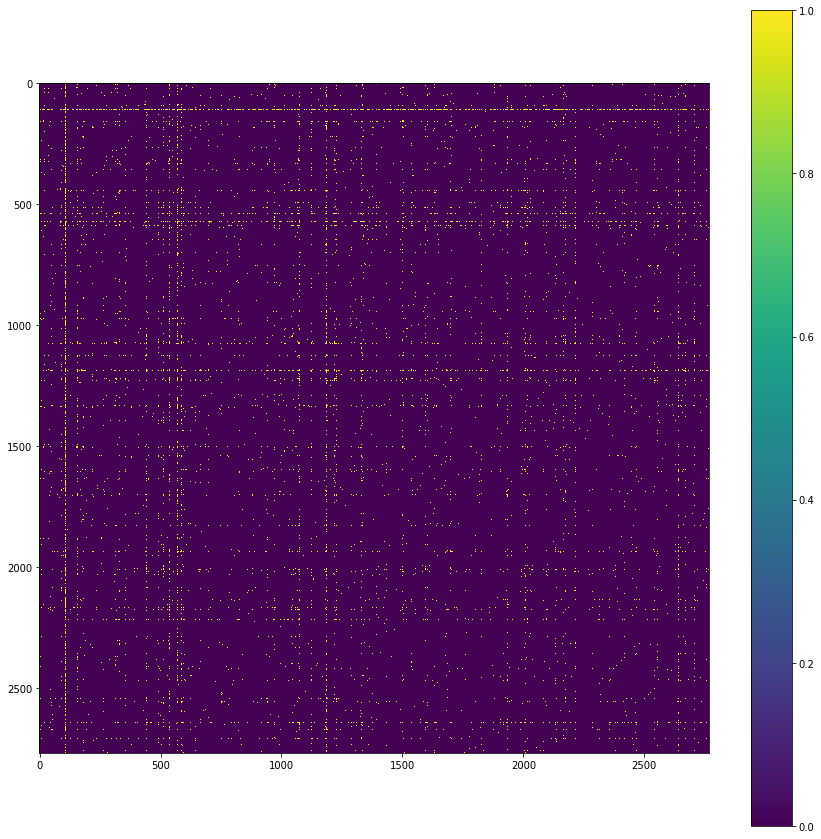

In [7]:
# Show adjacency matrix heatmap
fig, ax = plt.subplots(figsize=(15, 15))
_ = plt.imshow(X, cmap ='viridis')
_ = plt.colorbar()
_ = plt.show()

In [42]:
# Create a network of words
net = nx.from_numpy_matrix(X)

In [43]:
# Compute a layout for the network
layout = nx.spring_layout(net, 1e-01, iterations=10)

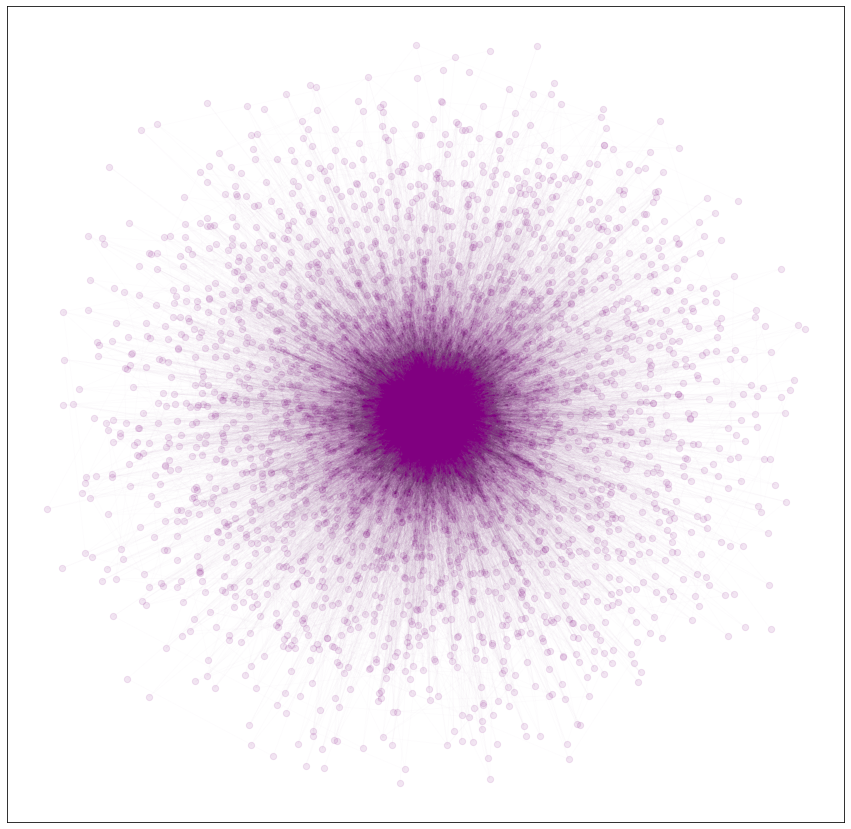

In [39]:
# Plot network
fig, ax = plt.subplots(figsize=(15, 15))
_ = nx.draw_networkx_nodes(net, pos=layout, node_size=40, alpha=.1, node_color='purple')
_ = nx.draw_networkx_edges(net, pos=layout, style='solid', alpha=.01, edge_color='purple')
# _ = nx.draw(net, pos=nx.spring_layout(net, 1e-01, iterations=10), node_size=10, alpha=.3)
_ = plt.plot()

In [46]:
layout

{0: array([ 0.26464823, -0.07763509]),
 1: array([ 0.36737323, -0.48633105]),
 2: array([ 0.18893705, -0.13270624]),
 3: array([-0.13479885,  0.24819973]),
 4: array([-0.0487632 , -0.02663954]),
 5: array([0.5766378 , 0.08625118]),
 6: array([-0.09427544, -0.18464413]),
 7: array([-0.6170491 , -0.42517072]),
 8: array([-0.4138492,  0.6479004]),
 9: array([ 0.02416233, -0.47217181]),
 10: array([-0.20682953, -0.25787616]),
 11: array([-0.85745072, -0.16176233]),
 12: array([-0.20473261,  0.16367233]),
 13: array([0.25265753, 0.31299114]),
 14: array([-0.4917905 , -0.42880726]),
 15: array([ 0.33020812, -0.14831273]),
 16: array([-0.07210208,  0.0384087 ]),
 17: array([ 0.40599048, -0.53276294]),
 18: array([-0.05158052,  0.17242527]),
 19: array([0.07376766, 0.04210459]),
 20: array([ 0.15317562, -0.25948551]),
 21: array([-0.436535  ,  0.12756661]),
 22: array([-0.09238598, -0.08220297]),
 23: array([0.18129188, 0.13444073]),
 24: array([-0.30759722, -0.0400162 ]),
 25: array([-0.08515

In [71]:
# Prepare the graph

# Get edges
edge_x = []
edge_y = []
for edge in net.edges():
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
# Create edges trace (i.e. the actual figure)
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='black'),
    hoverinfo='none',
    mode='lines',
    opacity=0.3
)
    
# Get nodes
node_x, node_y = [], []
for node in net.nodes():
    x, y = layout[node]
    node_x.append(x)
    node_y.append(y)
    
# Add nodes trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Viridis',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Node connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=1
    )
)

# Add attributes and set colouring
node_adjacencies, node_text = [], []
# Loop through each node in the network adjacency matrix
for node, adjacencies in enumerate(net.adjacency()):
    # Get the number of adjacent nodes
    node_adjacencies.append(len(adjacencies[1]))
    # Get the number of connections
    node_text.append('# of connections: '+str(len(adjacencies[1])))
# Add collected attributes to graph nodes
node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [72]:
# Create the graph
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Network graph made with Python',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

# Show graph in another browser window
fig.write_html('data/network_words.html')